### Step 1 : Include Libraries and Initialize Spark Session

In [1]:
#Import necessary libraries and initialize Spark Session
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract
from pyspark.sql import functions as F
from pyspark.sql.types import *

spark = SparkSession \
    .builder \
    .appName("Log Analysis in Spark") \
    .getOrCreate()


## Use-Case : Tracking Server Access Log <a class="anchor" name="use-case"></a>
For this case, a server is going to continuously send a records of a host who is trying to access some endpoint (url) from the web server. This data will be send from a kafka producer (<code>2.Lab-Task-KafkaProducer.ipynb</code>) which is reading the data from a txt file in the dataset provided (<code>logs/access_log.txt</code>).

Each line contains some valuable information such as:

1. Host
2. Timestamp
3. HTTP method
4. URL endpoint
5. Status code
6. Protocol
7. Content Size

The goal here is to perform some real time queries from this stream of data and be able to output the results in multiple ways.

### Step 2 : Load Kafka Stream 
Use the <code>readStream</code> to load data from the Kafka Producer <strong>2.Lab-Task-KafkaProducer.ipynb</strong>

<a class="anchor" id="lab-task-1"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">1. Lab Task: </strong> 
    Write the code below to readStream from the the producer into <code>df_urls</code> dataframe.
</div>

In [2]:
# Monitor the logs data stream for new log data
topic = "w10_access_log"
# df_urls = #WRITE THE CODE HERE
df_urls = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
    .option("subscribe", topic) \
    .load()

In [3]:
df_urls.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



## Data Preparation <a class="anchor" name="data-prep"></a>
We need to convert the data from the message in order to perform some queries. The steps to parse the data are:

1. Get message as a string from <code>value</code> which is binary.
2. Implement some regular expressions to capture specific fields in the message which is a line from the access log.
3. Extract the values using the regular expressions to create the dataframe.

In [4]:
# Get value of the kafka message
log_lines = df_urls.selectExpr("CAST(value AS STRING)")

# Parse out the common log format to a DataFrame
statusExp = r'\s(\d{3})\s'
generalExp = r'\"(\S+)\s(\S+)\s*(\S*)\"'
hostExp = r'(^\S+\.[\S+\.]+\S+)\s'

df_logs = log_lines.select(regexp_extract('value', hostExp, 1).alias('host'),
                         regexp_extract('value', generalExp, 1).alias('method'),
                         regexp_extract('value', generalExp, 2).alias('endpoint'),
                         regexp_extract('value', generalExp, 3).alias('protocol'),
                         regexp_extract('value', statusExp, 1).cast('integer').alias('status'))

df_logs.printSchema()

root
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- status: integer (nullable = true)



In [5]:
df_logs.dtypes

[('host', 'string'),
 ('method', 'string'),
 ('endpoint', 'string'),
 ('protocol', 'string'),
 ('status', 'int')]

## Data Streaming Processing 

<a class="anchor" id="lab-task-2"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">2. Lab Task: </strong> 
    Write a DataFrame query to filter out those requests that were not successful using <code>status !=200</code> filter.
</div>

In [7]:
# 1. DF that filters those requests that were not successful (status != 200)
#unsucess_df = #WRITE THE CODE HERE
unsucess_df = df_logs.filter(df_logs.status != 200)
#unsucess_df = df_logs[df_logs["status"]!=200]

In [8]:
unsucess_df.dtypes

[('host', 'string'),
 ('method', 'string'),
 ('endpoint', 'string'),
 ('protocol', 'string'),
 ('status', 'int')]

<a class="anchor" id="lab-task-3"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">3. Lab Task: </strong> 
    Write a DataFrame query count the number of requests by access status code
</div>

In [9]:
# 2. DF that keeps a running count of every access by status code
# status_count_df = #WRITE THE CODE HERE
status_count_df = df_logs.groupby("status").count()

In [10]:
status_count_df.printSchema()

root
 |-- status: integer (nullable = true)
 |-- count: long (nullable = false)



## Output sink <a class="anchor" name="output-sink"></a>
Before starting this section, run the kafka producer (<code>2.Lab-Task-KafkaProducer.ipynb</code>) that will send the data from the access log file.

In [11]:
# Create function to show values received from input dataframe
#foreachBatch(...) allows you to specify a function that is executed on the output data of every micro-batch of a streaming query.
def foreach_batch_function(df, epoch_id):
    df.show(20,False)

#### Display stream output in notebook <a class="anchor" name="foreachBatch"></a>

In [12]:
# Write output of status_count_df in output cell using the foreach_batch_function
# Control the amount of times output is displayed with trigger function
query1 = status_count_df.writeStream.outputMode("complete")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .start()

+------+-----+
|status|count|
+------+-----+
+------+-----+

+------+-----+
|status|count|
+------+-----+
|200   |22   |
+------+-----+

+------+-----+
|status|count|
+------+-----+
|200   |34   |
+------+-----+

+------+-----+
|status|count|
+------+-----+
|301   |2    |
|404   |1    |
|200   |43   |
+------+-----+

+------+-----+
|status|count|
+------+-----+
|301   |3    |
|404   |1    |
|200   |52   |
+------+-----+



In [13]:
query1.stop()

+------+-----+
|status|count|
+------+-----+
|301   |4    |
|404   |1    |
|200   |61   |
+------+-----+



In [14]:
query2 = unsucess_df.writeStream.outputMode("append")\
        .foreachBatch(foreach_batch_function)\
        .trigger(processingTime='5 seconds')\
        .start()

+----+------+--------+--------+------+
|host|method|endpoint|protocol|status|
+----+------+--------+--------+------+
+----+------+--------+--------+------+

+----+------+--------+--------+------+
|host|method|endpoint|protocol|status|
+----+------+--------+--------+------+
+----+------+--------+--------+------+

+----+------+--------+--------+------+
|host|method|endpoint|protocol|status|
+----+------+--------+--------+------+
+----+------+--------+--------+------+

+----+------+--------+--------+------+
|host|method|endpoint|protocol|status|
+----+------+--------+--------+------+
+----+------+--------+--------+------+

+----+------+--------+--------+------+
|host|method|endpoint|protocol|status|
+----+------+--------+--------+------+
+----+------+--------+--------+------+

+----+------+--------+--------+------+
|host|method|endpoint|protocol|status|
+----+------+--------+--------+------+
+----+------+--------+--------+------+

+--------------+------+----------------------------------+

In [15]:
query2.stop()

<a class="anchor" id="lab-task-4"></a>
<div style="background:rgba(0,109,174,0.2);padding:10px;border-radius:4px"><strong style="color:#FF5555">4. Lab Task: </strong> 
    Write the stream output to the <strong>memory sink</strong> and display the result using <strong>spark SQL</strong>
</div>

In [42]:
#WRITE THE CODE HERE TO WRITE OUTPUT TO MEMORY SINK
query3 = status_count_df \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("status_count_df") \
    .trigger(processingTime='5 seconds') \
    .start()

In [17]:
#WRITE THE CODE HERE TO QUERY THE TABLE FROM MEMORY SINK
spark.sql("select * from status_count_df").show()

+------+-----+
|status|count|
+------+-----+
|   200|   45|
+------+-----+



In [19]:
spark.sql("select * from status_count_df").show()

+------+-----+
|status|count|
+------+-----+
|   301|    2|
|   404|    2|
|   200|   80|
+------+-----+



In [20]:
spark.sql("select * from status_count_df").show()

+------+-----+
|status|count|
+------+-----+
|   301|   10|
|   404|    6|
|   200|  328|
+------+-----+



In [45]:
query3.stop()

In [43]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        ax.set_xlabel('Status')
        ax.set_ylabel('Count')        
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


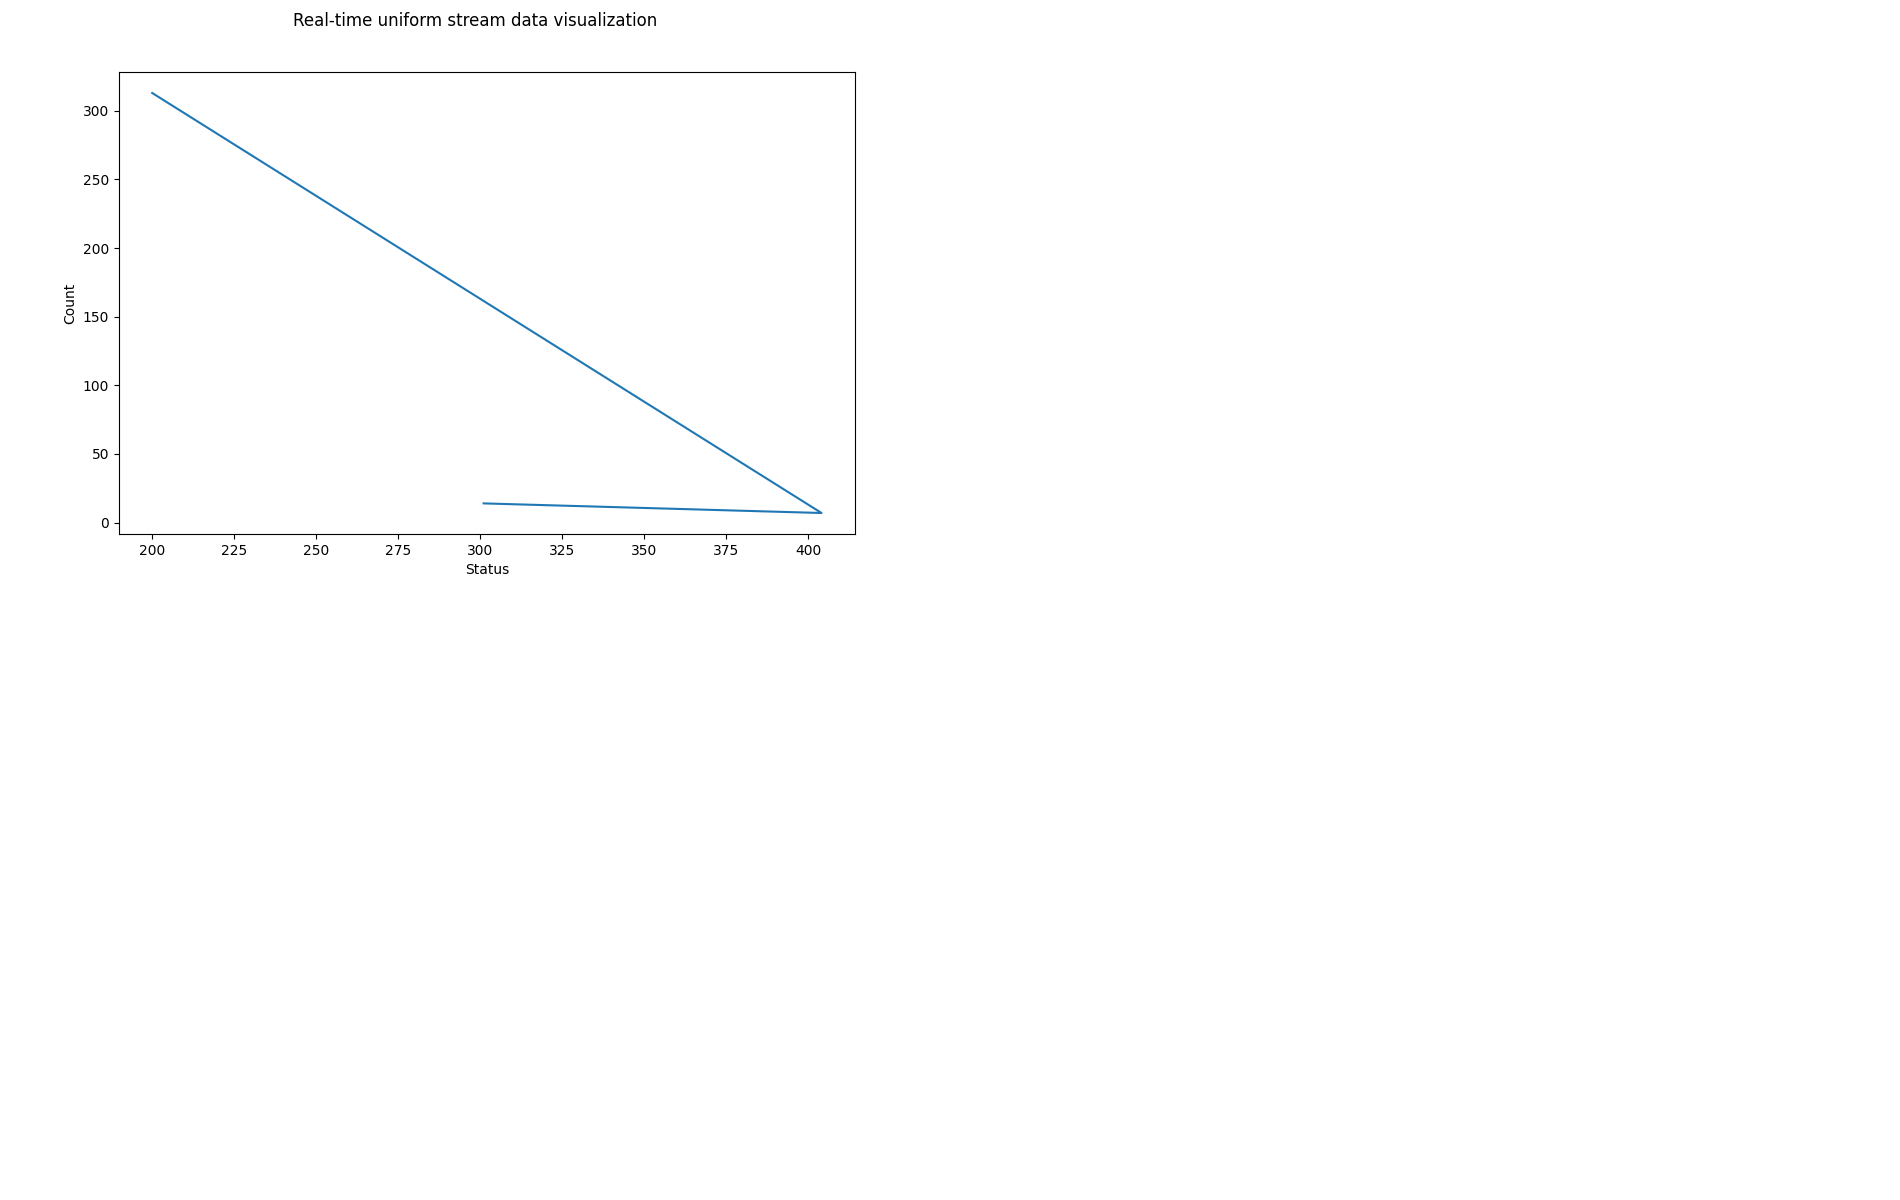

KeyboardInterrupt: 

In [44]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots()

while True:
    df = spark.sql("select * from status_count_df ").toPandas()
    x = df['status'].to_list()
    y = df['count'].to_list() 
    ax.clear()
#     print(x)
#     print(y)
    ax.plot(x,y)
    ax.set_xlabel('Status')
    ax.set_ylabel('Count') 
    fig.canvas.draw()
    time.sleep(1)